# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Achieving high accuracy

The present notebook is devoted to achieving high accuracy with the fast marching method. Let us recall that the standard discretization of the eikonal equation, for a problem with a point source, achieves the accuracy
$$
    \mathcal O(h \ln(h) ),
$$
where $h>0$ is the discretization grid scale. This is enough for a number of problems, but insufficient for other applications. 


In order to reduce this error, we use a combination of the three following approaches:
* *Second and third order finite differences* (**order** key). Numerical solvers of eikonal equations typically rely on first order upwind finite differences. Higher order finite differences can however be used at the 'recompute' stage, provided they are complemented with cautious fallback strategies, in view of their instability.
* *Equation factoring at the source(s)* (**factoringMethod** key). The solution of the eikonal equation has a non-differentiable singularity at the source point, which yields inaccurate finite differences in its neighborhood. Equation factoring methods correct for these systematic errors, by relying on an analytical expression of the singularity.
* *Spreading seed information* (**seedRadius** key). By default the seed position is rounded to the closest grid point, producing a systematic $\mathcal O(h)$ error, unless the provided seed falls exactly on a seed point. The seedRadius option replaces the given off-grid seed point with a small set of on-grid seed points equipped analytic estimates of the solution.


Some possible additional difficulties may however cause the above techniques to be inoperant. For instance:
* *Discontinuities in the metric*. Non-smooth data yields non-smooth solutions, which are not amenable to high order methods.
* *Obstacles in the domain* Secondary sources, created by the obstacles, are currently not handled by the equation factoring method. In addition, the fact that these sources are located on the domain boundary creates numerical difficulities.
* *Non holonomic models (curvature penalization)* The solutions to these models have a severe singularity at the source, which generally does not have an analytic expression. In addition, our implementation involves a relaxation, with parameter $\epsilon>0$, which is another source of error.


[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Poincare model of the hyperbolic plane](#1.-Poincare-model-of-the-hyperbolic-plane)
    * [1.1 The seedRadius key](#1.1-The-seedRadius-key)
    * [1.2 (Static) Equation factoring](#1.2-(Static)-Equation-factoring)
    * [1.3 Second order scheme](#1.3-Second-order-scheme)
    * [1.4 Third order scheme, and semi-Lagrangian numerical methods](#1.4-Third-order-scheme,-and-semi-Lagrangian-numerical-methods)
  * [2. A Riemannian metric](#2.-A-Riemannian-metric)
    * [2.1 Trying the various numerical scheme enhancements](#2.1-Trying-the-various-numerical-scheme-enhancements)
  * [3. A Rander metric](#3.-A-Rander-metric)
  * [4. Metric arising from seismology.](#4.-Metric-arising-from-seismology.)
  * [5. Additional discussion](#5.-Additional-discussion)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HighAccuracy','FMM'))

In [2]:
from agd import Eikonal
from agd import Metrics
from agd.Metrics.Seismic import Hooke
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Figures/HighAccuracy'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def LInfNorm(a): return np.max(np.abs(a))
def L1Norm(a):   return np.sum(np.abs(a))/a.size

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,Metrics,Hooke,ad
    [Eikonal,Metrics,Hooke,ad] = rreload([Eikonal,Metrics,Hooke,ad],rootdir='..')

## 1. Poincare model of the hyperbolic plane

The hyperbolic plane model is determined by the following (isotropic) metric
$$
    F_p(v) := \frac {\|v\|} {p_y},
$$
where $p = (p_x,p_y)$ belongs to the half plane $p_x \in \mathbb R$, $p_y > 0$. The distance between two points has the analytic expression
$$
    d(p,q) = \ln \frac{ |p - \overline q| + | p - q| }{|p - \overline q| - | p - q| },
$$
where $q = (q_x,q_y)$ and $\overline q = (q_x,-q_y)$. 

In the following example, we restrict our computations to the sub-domain $[-0.5,0.5] \times [1,2] \subset \mathbb R \times \mathbb R^{++}$.

In [6]:
def PoincareCost(q):
    """
    Cost function defining the Poincare half plane model of the hyperbolic plane.
    """
    return 1/q[1]

def PoincareDistance(p,q):
    """
    Distance between two points of the half plane model of the hyperbolic plane.
    """
    a = p[0]-q[0]
    b = p[1]-q[1]
    c = p[1]+q[1]
    d = np.sqrt(a**2+b**2)
    e = np.sqrt(a**2+c**2)
    return np.log((e+d)/(e-d))

In [7]:
dimx=100
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed': [0.,1.5],
    'exportValues':1.,
})
hfmIn.SetRect(sides=[[-0.5,0.5],[1,2]],dimx=dimx,sampleBoundary=True)
hfmIn.SetUniformTips((6,6))
    
X,Y = hfmIn.Grid()
hfmIn['cost'] = PoincareCost((X,Y))

In [8]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.002485 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


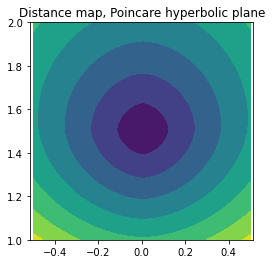

In [9]:
plt.figure(figsize=[4,4]); plt.title('Distance map, Poincare hyperbolic plane'); plt.axis('equal'); 
plt.contourf(X,Y,hfmOut['values']);

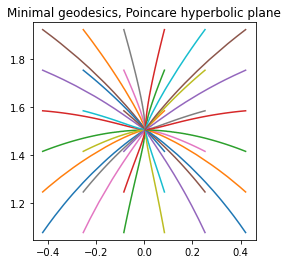

In [10]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Poincare hyperbolic plane'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

Next we compare the numerical results with the analytic expression of the distance.

In [11]:
ExactSolution = PoincareDistance(hfmIn['seed'],(X,Y))

In [12]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution  - hfmOut['values']) )

Max error :  0.014974751023088206
Average error :  0.0055575705831370096


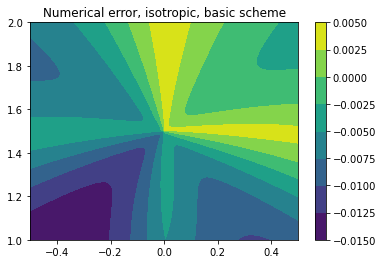

In [13]:
plt.title("Numerical error, isotropic, basic scheme")
plt.contourf(X,Y,ExactSolution - hfmOut['values'])
plt.colorbar();

### 1.1 The seedRadius key

In the above experiment with the Poincare model, as in most typical uses of the fast marching method we suspect, the seed point falls off the discretization grid. This results in a $\mathcal O(h)$ error, which can be corrected with the option **seedRadius**, with the following effects.

* **seedRadius** $= 0$ (default).  The seed is rounded to the nearest grid point, producing the largest error. This is however the only available option with e.g. non-holonomic models, for which no analytic approximation of the solution is available. In addition, this default can be required for some use cases involving automatic differentiation [link](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A2_Sensitivity.ipynb)

* **seedRadius** $=r>0$. All the grid points $q$ within radius $r$, *measured in pixels*, of the provided seed $p_*$ are initialized with the seed values 
$$
    %v(q) := 
    u(p_*) + \frac 1 2 (F_{p_*}(q-p_*) + F_q(q-p_*)).
$$

* **seedRadius** $=r<0$. All the grid points $q$ within radius $|r|$ of the provided seeds are set as seeds, with the above value, as well as the points which can be reached in one step using the numerical scheme stencil.

<!---

* **spreadSeeds = 0**. The corners $q$ of the grid cell (square or cube) containing the provided seed point $p_*$ are used as seeds, with the seed values 


* **spreadSeeds = 1**. A few additional grid points are used as seeds, corresponding to one step of the fast marching scheme.

In the Poincare half plane instance, an error reduction by $20\%$ (resp $35\%$) is obtained by choosing $\mathbf {spreadSeeds}=0$ (resp. $\mathbf {spreadSeeds}=1$) instead of the default.
--->

A typical value, in two dimensions, is seedRadius $=1.5$.

In [14]:
hfmIn['seedRadius'] = 1.5

In [15]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Fast marching solver completed in 0.002397 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [16]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

# The four grid points enclosing the provided seed are used
print("spreadedSeeds", hfmOut['spreadedSeeds'])

Max error :  0.01024015982151194
Average error :  0.005398508223713214
spreadedSeeds [[ 0.00505051  1.50505051]
 [-0.00505051  1.49494949]
 [-0.00505051  1.50505051]
 [ 0.00505051  1.49494949]]


In [17]:
hfmIn['seedRadius'] = -1.5

In [18]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Fast marching solver completed in 0.002553 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [19]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

# Twelve grid points are used, around the provided seed
print("spreadedSeeds : ", hfmOut['spreadedSeeds'])
print("spreadedSeedValues : ", hfmOut['spreadedSeedValues'])

Max error :  0.009375865003666828
Average error :  0.004553988978738238
spreadedSeeds :  [[ 0.00505051  1.50505051]
 [-0.00505051  1.49494949]
 [-0.00505051  1.50505051]
 [ 0.00505051  1.49494949]
 [-0.01515152  1.49494949]
 [-0.00505051  1.48484848]
 [-0.01515152  1.50505051]
 [-0.00505051  1.51515152]
 [ 0.00505051  1.48484848]
 [ 0.01515152  1.49494949]
 [ 0.00505051  1.51515152]
 [ 0.01515152  1.50505051]]
spreadedSeedValues :  [0.00475367 0.00476971 0.00475367 0.00476971 0.01066539 0.01070172
 0.01062953 0.01059416 0.01070172 0.01066539 0.01059416 0.01062953]


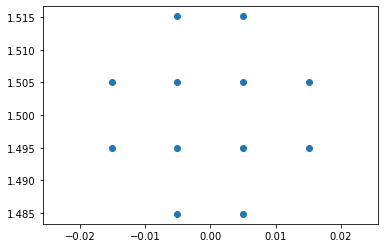

In [20]:
plt.axis('equal')
plt.scatter(*hfmOut['spreadedSeeds'].T);

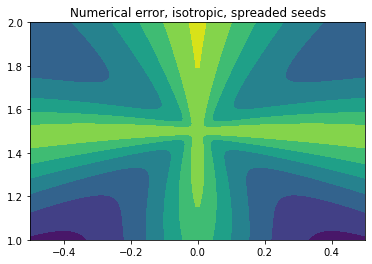

In [21]:
plt.title("Numerical error, isotropic, spreaded seeds")
plt.contourf(X,Y,ExactSolution - hfmOut['values']);

### 1.2 (Static) Equation factoring

A substantial part of the numerical error of fast marching solvers is due to the singularity of the solution at the point source, the seed here denoted $p_*$, which makes the finite differences inaccurate. In order to correct for this error, factoring methods substract an analytical expression of the singularity from the numerical solution in the process of evaluating finite differences.

The parameters enabling this modification of the numerical scheme are the following:
* **factoringRadius** (in pixels, default is 10) Radius of the region, around the seeds, where to use equation factoring. 
Use a very large value, or a negative value, to implement factorization over the whole domain (this has a memory and computational cost).
* **factoringPointChoice** ('Seed', 'Both'). Dictates the analytic expression of the solution used in equation factoring. 
    - 'Seed' (Default, equivalently 'Key') has the cheapest numerical cost, and uses the approximant
    $$
        u(q) \approx 
        %u(p_*) + 
        F_{p_*}(q-p_*).
    $$
    - 'Both' is more accurate than the previous approximant. However, the difference is only visible when combined with high order schemes.
    In addition it is more computationally expensive in certain cases, mostly due to implementation details (Python instead of c++ code).
    $$
        u(q) \approx 
        %u(p_*) + 
        \frac 1 2 (F_{p_*}(q-p_*) + F_q (q-p_*) ).
    $$

<!---
* **factoringMethod** ('Static', 'None') Use 'Static' factoring to account for point source singularities. Default is 'None'.

Factoring is often not performed in the entire domain, since it has a numerical cost, and it looses relevance once analytic expression isn't anymore a good approximation of the solution.
--->

<!---
    - 'Current' uses the approximant 
    $$
        u(q) \approx 
        %u(p_*) + 
        F_q (q-p_*).
    $$
    This is not really an advised option, since it is slightly more expensive than 'Key' and not more accurate.

--->

In [22]:
hfmIn.update({
    'factoringRadius':dimx*0.2, 
    'factoringPointChoice':'Seed'
})

In [23]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field exportFactoring defaults to 0
Fast marching solver completed in 0.002656 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [24]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  0.004124959564815067
Average error :  0.0010588203740673834


Numerical error is considerably reduced in the factoring region, around the seed. The singularity is not anymore a source of error.
However, without a higher order scheme the overal error is not (much) reduced, since it is dominated by the regions far from the origin.

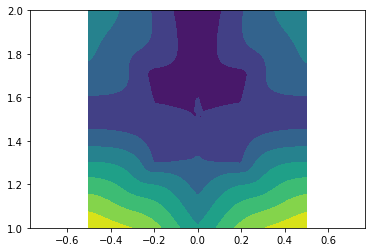

In [25]:
plt.axis('equal')
plt.contourf(X,Y,hfmOut['values']-ExactSolution);

### 1.3 Second order scheme

The second order scheme is intended to reduce numerical error far from the solution singularity. It is complementary to the factorisation, discussed in the previous paragraph, which is devoted to the neighborhood of the source.

In [26]:
hfmIn['order']=2

In [27]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field exportFactoring defaults to 0
Fast marching solver completed in 0.003293 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


The overall numerical error is strongly reduced, by a factor 20 to 40 in this instance, in respectively $L^\infty$ or $L^1$ norm.

In [28]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  0.00031159216527243405
Average error :  7.41626202343413e-05


The second order scheme is much less efficient when it is not combined with equation factoring. 

In [29]:
hfmIn2 = hfmIn.copy()
hfmIn2.pop('factoringRadius',None);

In [30]:
hfmOut = hfmIn2.Run()

Field verbosity defaults to 1
Fast marching solver completed in 0.003237 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
***** Warning ! *****
Unused fields from user: factoringPointChoice 
********************


In [31]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  0.0022531467146763573
Average error :  0.0009527399338253569


### 1.4 Third order scheme, and semi-Lagrangian numerical methods

The second order scheme is expected, combined with point source factorisation, is expected to be accurate enough for most applications. However, as an experimental feature, a third order scheme is implemented as well.

**Strict causality** According to our numerical experiments, third order accuracy is however only achieved with a *strictly causal* scheme. This is an issue, since the Eulerian implementation of the eikonal equation is only *weakly causal*.


**Semi-Lagrangian schemes** 
These schemes are based on a discretization of Bellman's optimality principle, and by an adequate choice of discretization stencil, do obey a strict causality property. 
We emulate an isotropic metric as a special case of a Rander metric, which is implemented using a strictly causal semi-Lagrangian scheme in the HFM-Library. See the relevant notebook [A III, Rander metrics](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/A6_Rande.ipynb) for details on this model.


**Accuracy of semi-Lagrangian schemes, second order**
Already with the second order scheme, the better angular resolution of the semi-Lagrangian scheme yields a substantial error reduction. Numerical error is cut by a factor 4 or 2, in the $L^\infty$ or $L^1$ norm respectively. Note however than the semi-Lagrangian scheme is more costly numerically.

In [32]:
Zero = np.zeros(X.shape)
hfmIn.update({
    'model':'Rander2',
    'metric':Metrics.Isotropic(PoincareCost((X,Y)) ) # Will be cast to a Rander metric
})
hfmIn.pop('cost',None);

In [33]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field exportFactoring defaults to 0
Fast marching solver completed in 0.009657 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [34]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  9.257219017949625e-05
Average error :  2.2529463482949794e-05


A further error reduction is achieved by selecting the more accurate factorisation. Error is cut by a factor 2 approximately.

<!---
hfmIn2 = hfmIn.copy()

from agd import FiniteDifferences as fd
def exact_fact(x): return PoincareDistance(hfmIn['seed'],x)
def both_analytic_fact(x):
    seed = fd.as_field(hfmIn['seed'],x.shape[1:])
    return ad.Optimization.norm(x-seed,axis=0) * (1/seed[1] + 1/x[1]) /2

def both_interp_fact(x):
    metric = hfmIn2['metric']
    seed = hfmIn2['seed']
    metric.set_interpolation(hfmIn2.Grid(),order=3)
    diff = lambda x : x-fd.as_field(seed,x.shape[1:],depth=1)
    return 0.5*(metric.at(seed).norm(diff(x)) + metric.at(x).norm(diff(x)))


hfmIn2.SetFactor(value = both_interp_fact);
hfmIn2['order']=3
--->

In [35]:
hfmIn['factoringPointChoice'] = 'Both'

In [36]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.009658 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [37]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  4.8466692704585146e-05
Average error :  1.3824067363141873e-05


Finally, the smallest error is obtained with the third order scheme. Error is cut by a additional factor 7 approximately.

In [38]:
hfmIn['order']=3

In [39]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.010278 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


In [40]:
print("Max error : ",     LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(  ExactSolution - hfmOut['values']) )

Max error :  5.825290542715855e-06
Average error :  1.7760256167372104e-06


Overall, in favorable cases, numerical error can be reduced by three orders of magnitude with the adequate  enhancements to the scheme.

In [41]:
print("LInf ratio : ", 0.014974751023088206/1.0486664716702343e-05)
print("L1 ratio : ", 0.0055575705831370096/3.2811874264378546e-06)

LInf ratio :  1427.9803376604182
L1 ratio :  1693.768096987516


## 2. A Riemannian metric

In this section, we demonstrate high order accuracy for Riemannian anisotropic fast marching. For that purpose we introduce a synthetic Riemannian metric which is the image by a diffeomorphism of an usual norm, so that an exact expression of the distance map is known. 

More precisely, consider the diffeomorphism defined at each point $p = (x,y)$ by 
$$
    f(x,y) := (x,y+ \sin(\pi x) /2)
$$
and the matrix $M$ of diagonal entries $(0.5^2,1)$. We let 
$$
    \mathcal M(p) := (Jf(p))^T \cdot M \cdot Jf(p),
$$
where $Jf(p)$ is the Jacobian matrix of $f$ at $p$. The distance between $p,q$ is thus 
$$
    d_{\mathcal M}(p,q) = \|f(p) - f(q)\|_M.
$$


In [42]:
diagCoef = (0.5**2,1) # Diagonal coefficients of M

def diff(x,y,α=0.5): return ad.array([x,y+α*np.sin(np.pi*x)]) # Diffeomorphism f

def RiemannMetric(diag,diff,x,y): 
    X_ad = ad.Dense.identity(constant=(x,y),shape_free=(2,))
    Jac = np.moveaxis(diff(*X_ad).gradient(),0,1)
    return Metrics.Riemann.from_diagonal(diag).inv_transform(Jac)

def RiemannExact(diag,diff,x,y):
    a,b = diag
    fx,fy = diff(x,y)
    return np.sqrt(a*fx**2+b*fy**2)

The metric is rather strongly anisotropic, with ratio of larger than $7$ of the fastest to the smallest speed, at a given point, depending on the direction.

In [43]:
RiemannMetric(diagCoef,diff,0,0).anisotropy()

7.297774117194738

In [44]:
dimx=200
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed': [0.,0.],
    'exportValues':1.,
    'geodesicSolver':'Discrete'
})
hfmIn.SetRect(sides=[[-1,1],[-0.5,0.5]],dimx=dimx)
hfmIn.SetUniformTips((6,6))

X,Y = hfmIn.Grid()

In [45]:
hfmIn['metric'] = RiemannMetric(diagCoef,diff,X,Y)

In [46]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1


Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009792 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


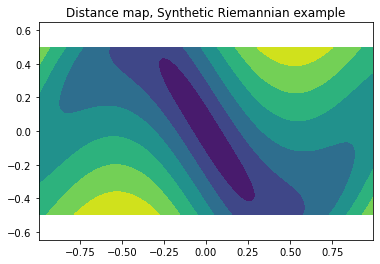

In [47]:
plt.title('Distance map, Synthetic Riemannian example'); plt.axis('equal')
plt.contourf(X,Y,hfmOut['values']);

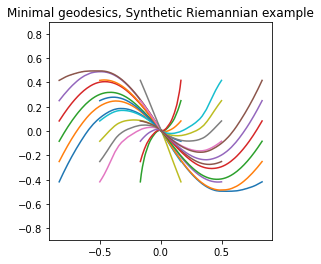

In [48]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Synthetic Riemannian example'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

The exact solution is, by design, explicit.

In [49]:
ExactSolution = RiemannExact(diagCoef,diff,X,Y)

There are some shadow zones in the domain : the geodesics reaching these points, according to the exact model, should have gone outside the rectangle. Clearly, the numerical solution cannot agree with the exact solution on these points, which are thus removed from the error computation.

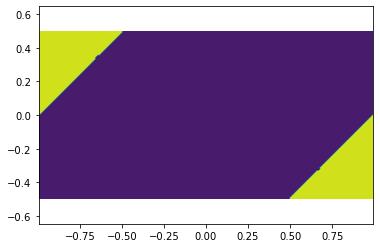

In [50]:
shadow = np.abs(X-Y)>=1
plt.axis('equal')
plt.contourf(X,Y,shadow);

In [51]:
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Max error :  0.02908883254421535
Average error :  0.009789067979843967


### 2.1 Trying the various numerical scheme enhancements

Spreading the seed information on the four adjacent pixels already cuts the error in half.

In [52]:
hfmIn['seedRadius']=1.5
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Fast marching solver completed in 0.010724 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.01687222010081446
Average error :  0.005061895743398188


Curiously, spreading the seed information a little further does not help, at all.
Note that the grid points used depend on the discretization stencil, which is here anisotropic.

**TODO**: inquire into this.

In [53]:
hfmIn['seedRadius']=-1.5
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Fast marching solver completed in 0.010506 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.017551131842353573
Average error :  0.004929746282214543


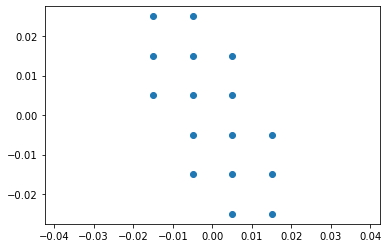

In [54]:
plt.axis('equal')
plt.scatter(*hfmOut['spreadedSeeds'].T);

Enabling equation factoring only helps, around the center.
Because the metric varies quickly, this technique does seem to add to the error in certain regions.

In [55]:
hfmIn['factoringRadius']=30
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field order defaults to 1
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.011815 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.021587997803615977
Average error :  0.006178899901994556


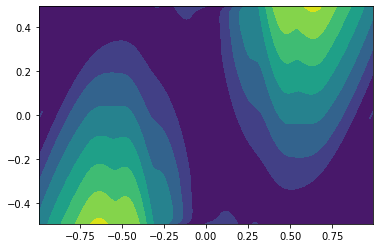

In [56]:
plt.contourf(X,Y,np.abs(error));

The second order scheme has a huge impact on accuracy. Errors are cut by a factor 10 to 40, in $L^\infty$ and $L^1$ respectively.

In [57]:
hfmIn['order']=2
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.012436 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.0016242966864593589
Average error :  0.00012257060869058333


The semi-Lagrangian scheme does help, particularly in the max norm.

In [58]:
hfmIn['model']='Rander2'
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.026929 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.0003200442475776999
Average error :  8.939994309356508e-05


The last two arrows for accuracy enhancement, namely accurate factorisation and the third order scheme, help only a little. The $L^1$ error is cut by a factor two or three, while the $L^\infty$ error actually increases a bit. This is due, we believe, to the strong anisotropy and the relatively modest resolution used. 

(Recall that stencils are larger in strongly anisotropic instances, which reduces the effective resolution in comparison with the isotropic test case.)

In [59]:
hfmIn['factoringPointChoice']='Both'
hfmOut = hfmIn.Run()

error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.02729 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.0006308191190576018
Average error :  0.00012637159500778635


In [60]:
hfmIn['order']=3

hfmOut = hfmIn.Run()
error = ExactSolution - hfmOut['values']; error[shadow]=0.
print("Max error : ",LInfNorm(error) )
print("Average error : ", L1Norm(error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.027145 s.
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.00040367256991502565
Average error :  2.8803119686151257e-05


In [61]:
print("LInf ratio : ", 0.02908883254421535/0.0004451630035827159)
print("L1 ratio : ", 0.009789067979843967/3.436922647391891e-05)

LInf ratio :  65.34422741805933
L1 ratio :  284.8207243556209


## 3. A Rander metric

A Rander metric is, we recall, the sum of a Riemannian metric and a linear asymmetric perturbation. 
$$
    F_p(v) := \sqrt{v \cdot \mathcal M(p) \cdot v} + <\omega(p), v>.
$$
The perturbation is subject to a smallness condition: for each point $p$
$$
    \omega(p) \cdot \mathcal M(p)^{-1} \cdot \omega(p) < 1.
$$
In the special case where $\omega$ is a gradient field, the Riemannian distance and the Rander distance obey a simple relation:
$$
    d_F(p,q) = d_{\mathcal M}(p,q) + v(q)-v(p),
$$
if $\omega = \nabla v$.
We rely on this identity to build a synthetic test case with an explicit solution.

Let $\mathcal M\equiv M$ be constant, and $\omega = \nabla v$, with
$$
\begin{aligned}
    M &= \begin{pmatrix} 1.25 & 0.5 \\ 0.5 & 2 \end{pmatrix}, &
    v(x,y) &= \gamma \sin(\pi x) \sin(\pi y) / \pi,
\end{aligned}
$$
and $\gamma = 0.8$. Since the smallest eigenvalue of $M$ is one, the smallness condition is satisfied if $|\gamma|<1$.


In [62]:
M=((1.25,0.5),(0.5,2.))

def v(x,y,γ): return γ*np.sin(np.pi*x)*np.sin(np.pi*y)/np.pi

def RanderMetric(x,y,γ=0.8):
    X_ad = ad.Dense.identity(constant=(x,y),shape_free=(2,))
    omega = v(*X_ad,γ).gradient()
    return Metrics.Rander(M,omega)

def RanderSolution(x,y,γ=0.8):
    return Metrics.Riemann(M).norm((x,y)) + v(x,y,γ)

In [63]:
dimx=200
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1.,
})
hfmIn.SetRect(sides=[[-2,2],[-2,2]],dimx=dimx)
hfmIn.SetUniformTips((6,6))

X,Y = hfmIn.Grid()
hfmIn['metric']=RanderMetric(X,Y)

In [64]:
np.max(hfmIn['metric'].anisotropy_bound()) # Only an upper bound

10.679739555817132

In [65]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.051106 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


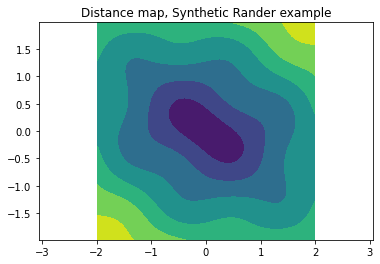

In [66]:
plt.title('Distance map, Synthetic Rander example'); plt.axis('equal')
plt.contourf(X,Y,hfmOut['values']);

Because of the particular structure of the metric, the geodesics are straight lines towards the seed point.

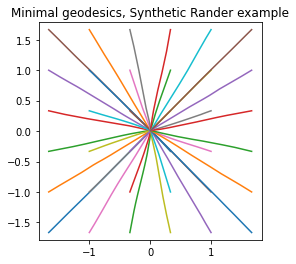

In [67]:
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Synthetic Rander example'); plt.axis('equal'); 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 

In [68]:
ExactSolution = RanderSolution(X,Y)
shadow = X>=1.9

In [69]:
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Max error :  0.03476786943748733
Average error :  0.015537521580026198


**Trying the various enhancements.**
The *seedRadius* option has a significant impact, by eliminating a systematic $\mathcal O(h)$ error due to the seed approximation by a grid point. Factorisation is not much useful alone, since it acts only locally around the seed. However it enables higher order finite differences, which considerably reduce error.

In [70]:
hfmIn['seedRadius']=1.5

hfmOut = hfmIn.Run()
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Fast marching solver completed in 0.051116 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.018624543507695712
Average error :  0.006593869473546114


In [71]:
hfmIn['factoringRadius']=20

hfmOut = hfmIn.Run()
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.049869 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.014195527091016569
Average error :  0.005109244237188322


In [72]:
hfmIn['order']=2

hfmOut = hfmIn.Run()
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.060228 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.007552076286743592
Average error :  0.0008782499863001231


In [73]:
hfmIn['factoringPointChoice']='Both'

hfmOut = hfmIn.Run()
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.057213 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.0065116227920483105
Average error :  0.000807641468774751


In [74]:
hfmIn['order']=3

hfmOut = hfmIn.Run()
print("Max error : ",LInfNorm(ExactSolution - hfmOut['values']) )
print("Average error : ", L1Norm(ExactSolution - hfmOut['values']) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Fast marching solver completed in 0.055272 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Max error :  0.005701237453601404
Average error :  0.00015955694935521666


In [75]:
print("LInf ratio : ", 0.03476786943726218/0.006871137608516875)
print("L1 ratio : ", 0.015537521580015985/0.00015772991402875582)

LInf ratio :  5.0599873584494794
L1 ratio :  98.50713275088283


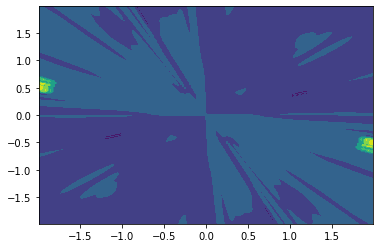

In [76]:
plt.contourf(X,Y,ExactSolution - hfmOut['values']);

## 4. Metric arising from seismology.

The metrics considered in this section are defined in terms of a Hooke tensor, representing the elastic properties of the ambient geological medium. Such metrics can be rotated and multiplied by a scalar. However they are not affine invariant, in contrast with e.g. Riemannian, Rander, or asymmetric quadratic metrics considered above. (Affine change of coordinates can be applied nevertheless, but this changes the structure of the metric, see below.)

We use a conformal change of coordinates to produce an analytic example with a known solution. 

**Note on computation time.**
In the experiments presented below, it appears that producing the source factorization on the whole domain is approximately $12$ times longer than running the fast marching algorithm. This makes no sense from the complexity standpoint, and it is only because the fast marching is written in C++, whereas the source factorization is written in Python, with a costly abstraction layer related with automatic differentiation.

We avoid this issue by using source factorization only on a small subdomain of the whole domain.

In [77]:
def ConformalMap(x):
    """
    Implements the mapping x -> (1/2) * x^2, where x is seen as a complex variable.
    """
    return ad.array([0.5*(x[0]**2-x[1]**2), x[0]*x[1]])

def ConformalApply(norm,f,x,decomp=True):
    """
    Applies a conformal change of coordinates to a norm.
    decomp : decompose the Jacobian into a scaling and rotation.
    """
    x_ad = ad.Dense.identity(constant=x,shape_free=(2,))
    Jac = np.moveaxis(f(x_ad).gradient(),0,1)
    if not decomp: return norm.inv_transform(Jac)
    
    # Assuming Jac is a homothety-rotation
    α = np.power(lp.det(Jac), 1/norm.vdim)
    R = Jac/α
    return norm.with_cost(α).rotate(lp.transpose(R))
    

def MappedNormValues(norm,f,x,seed):
    seed = fd.as_field(seed,x.shape[1:])
    return norm.norm(f(x)-f(seed))

In [78]:
hfmIn = Eikonal.dictIn({
    'model':'Seismic2',
    'seeds':np.array([[2.,0.]]),
    'exportValues':1.,
})

# Set the coordinate system
hfmIn.SetRect([[1,3],[-1,1]],dimx=200)
X = hfmIn.Grid()

# Set the metric
norm = Hooke.mica[0].extract_xz().rotate_by(0.5)
hfmIn['metric'] = ConformalApply(norm, ConformalMap, X)

ExactSolution = MappedNormValues(norm,ConformalMap,X,hfmIn['seed'])

If one ignores the conformal structure of the change of variables, then it cannot be directly applied to the Hooke tensor. As a result,  the structure of the metric changes a bit, becoming the `SeismicTopographic2` model, defined as the composition of a `Seismic2` norm and of an affine map. 

In [79]:
ConformalApply(norm, ConformalMap, X, decomp=False).model_HFM() # Ignore the conformal structure of the mapping

'SeismicTopographic2'

The following experiments illustrate that the accuracy of the eikonal solver remarkably increases as are introduced, successively: source factorization, second order scheme, accurate source factorization, third order scheme.

In [80]:
%%time
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.21792 s.
Max error :  0.0027199166797670093
Average error :  0.0006722545988148448
CPU times: user 163 ms, sys: 20.4 ms, total: 183 ms
Wall time: 509 ms


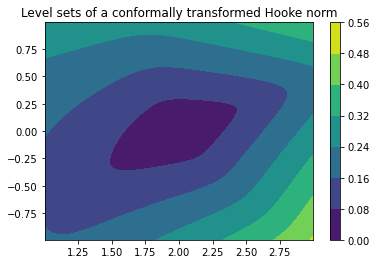

In [81]:
plt.title("Level sets of a conformally transformed Hooke norm")
plt.contourf(*X,hfmOut['values']) 
plt.colorbar();

In [82]:
%%time
hfmIn['factoringRadius']=20 # Source factorization is only on a small subdomain
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.233192 s.
Max error :  0.0013257151435809855
Average error :  0.0004357188696826151
CPU times: user 6.92 ms, sys: 8.88 ms, total: 15.8 ms
Wall time: 510 ms


In [83]:
%%time
hfmIn['order']=2
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.275546 s.
Max error :  5.859369152477756e-05
Average error :  1.5824607552193606e-05
CPU times: user 6.68 ms, sys: 8.28 ms, total: 15 ms
Wall time: 550 ms


In [84]:
%%time
hfmIn['factoringPointChoice']='Both'
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field seedRadius defaults to 2
Fast marching solver completed in 0.286416 s.
Max error :  3.8313346658214176e-05
Average error :  5.963835815658736e-06
CPU times: user 569 ms, sys: 38 ms, total: 607 ms
Wall time: 783 ms


In [85]:
%%time
hfmIn['order']=3
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field seedRadius defaults to 2
Fast marching solver completed in 0.296115 s.
Max error :  6.020494908276497e-06
Average error :  9.039280673235941e-07
CPU times: user 542 ms, sys: 28.1 ms, total: 570 ms
Wall time: 756 ms


As mentioned in the introduction of this section, using source factorization over the whole domain has a significant cost, due to the slow Python-based computation of the factor. Nevertheless this could be easily fixed, at least in principle, and it further improves the accuracy a bit, in the average at least.

In [86]:
%%time
hfmIn['factoringRadius']=-1 # Source factorization over the whole domain
hfmOut = hfmIn.Run()

error = hfmOut['values'] - ExactSolution
print("Max error : ",     LInfNorm(error) )
print("Average error : ", L1Norm(  error) )

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field seedRadius defaults to 2
Fast marching solver completed in 0.33511 s.
Max error :  7.158982098687261e-06
Average error :  4.733269393667884e-07
CPU times: user 5.11 s, sys: 391 ms, total: 5.5 s
Wall time: 3.73 s


## 5. Additional discussion

Solving an eikonal equation to high accuracy (second or third order) is a non-trivial matter, and the following points must be considered:
* (Smoothness of the data) 
If the problem data is not smooth, either the metric or the cost function, then high order accuracy usually cannot be achieved.
* (Smoothness of the solution) 
Even if the problem data is smooth, the solution may not be, thus again preventing high order accuracy. For instance asymmetric quadratic metrics (`AsymQuad` models) yield solutions at most once differentiable. Non-holonomic metrics yield solutions with complex non-smooth singularities, that cannot be factored (no simple closed form expression).
* (Semi-Lagrangian or Eulerian scheme) 
Semi-Lagrangian schemes, with a suitable choice of stencil, are *strictly causal*, implying that sufficiently small perturbations such as source factorization preserve the causality of the scheme. Eulerian schemes are not, and as a result are more limited in terms of achievable accuracy.
In particular the seedRadius must be sufficiently large, and third order accuracy is usually not achievable.
* (Single pass or iterative solver) High order schemes are not monotone, and as a result lack some stability properties. 
There is a standard way of handling this issue with the single pass fast marching method (only use the high order scheme in the post-processing step, before the node is accepted), but it does raise more significant problems with iterative solvers. As a result the GPU eikonal solver is limited to first order accuracy.
